<a href="https://colab.research.google.com/github/zachroyer/Music-Symbol-Classification/blob/main/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Part 1: Load/Analyze Data

##What is your dataset? Please describe your dataset and where you got it

My dataset of choice is titled "Music Notes Dataset". I obtained it on Kaggle uploaded by a user 'kishanj'.

## Description of Music Notes Dataset
This dataset contains a large set of one category of notes one might encounter while examining sheet music.

One image can correspond to the following labels:
*  Whole
*  Half
*  Quarter
*  Eighth
*  Sixteenth

Each note can be broken down in to three components (or a lack of one or more):
1.   Note Head
2.   Stem
3.   Flag

The change of these components is what determines how *long* a note is held for when playing it. The placement of the note determines *which* note to play on your desired instrument. This dataset omits that implicit feature by isolating the images to the features of a note, not its placement.

The Note Head is the circular portion of the note.
The Stem is the thin line that grows from the Note Head.
The Flag is the perpindicular tail on the end of a Stem.

# Self-Collected Test Data
In addition to the dataset from Kaggle, I also collected a small sample of test data myself. The data came from a digital scan of a physical copy of Minuet in D Minor (J.S. Bach) from the Schirmer's Library of Musical Classics Vol. 2066. This is a piece that I have personally studied on the piano.

With that digital scan, I cropped singular notes and organized them in a manner in which PyTorch's ImageFolder class can easily attribute each note to a class. The data was imported from Google Drive, although a copy is included in my submission. The folder structure looks like so:
```
- Eight
  | - eighth_1.jpg
  | - eighth_2.jpg
  | - ...
- Quarter
  | - quarter_1.jpg
  | - quarter_2.jpg
  | - ...
- ...
  |
  |
```
I chose to test my model on this collection of notes for two reasons:
1. It seemed fun! :)
2. I wanted to test whether I could generalize isolated notes (notes without any noise) to notes directly from sheet music which contains "noise" in the sense of additional markings that aren't always relevant to how *long* a note is played. I don't expect the model to do particularly well but it could help me understand the limitations of CNNs and data domain spaces.

##Load your dataset / Implement your dataloader

In [ ]:
# Installing dataset directly from Kaggle
!pip install kagglehub --silent

import kagglehub
download_path = kagglehub.dataset_download("kishanj/music-notes-datasets")
print(download_path)
path = download_path + "/datasets/datasets/Notes"
print("Downloaded to: ", path)


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --silent


100%|██████████| 12.0M/12.0M [00:01<00:00, 6.80MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/kishanj/music-notes-datasets/versions/4
Downloaded to:  /root/.cache/kagglehub/datasets/kishanj/music-notes-datasets/versions/4/datasets/datasets/Notes


In [ ]:
# Defining a Transform for training data with augmentation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1), # Guaranteeing only one color channel for efficiency
    transforms.Resize((64,64)), # Resizing image
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5)), # Normalizing pixel values to range from (0,1) and (-1,1) for stability
])

data = torchvision.datasets.ImageFolder(root=path, transform=transform) # Easily extract class information for data from directory structure using ImageFolder

In [ ]:
BATCH_SIZE = 64


# Splitting Data into random train, validation and test splits
train_split, val_split, test_split = torch.utils.data.random_split(data, [int(len(data)*0.8), int(len(data)*0.1), int(len(data)*0.1)])

# Wrapping random data in DataLoader for PyTorch
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE)
validation_loader = DataLoader(val_split, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)

##Dataset Analysis Statistics

5000


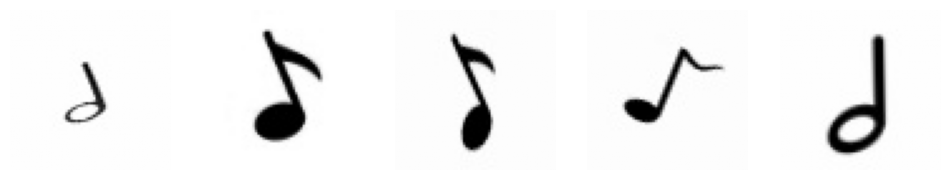

Number of data points (images) in each split per batch(train/val/test): 63/8/8


In [25]:
# code for collecting statistics from your dataset / plots and analysis

labels = data.targets
print(len(labels))



temp_train_iter = iter(train_loader)

fig, axes = plt.subplots(1, 5, figsize=(12,3))

for i in range(5):
  images, labels = next(temp_train_iter)
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap="gray")
  axes[i].axis("off")

plt.show()

print(f"Number of data points (images) in each split per batch(train/val/test): {len(train_loader)}/{len(validation_loader)}/{len(test_loader)}")


In [ ]:
print(data.shape)

AttributeError: 'ImageFolder' object has no attribute 'shape'

# Analysis

A description of the dataset
● Format of the inputs and outputs
● Number of examples in the train/val/test splits
● A visualization of at least 5 examples from your dataset
Summary statistics (e.g. for language datasets, you might include things such as the average lengths
of the inputs or the number of unique words).
● If possible, any visualizations of the dataset statistics.

## Format
The Formats of the inputs are '.jpg' images.
The data format of the outputs are


# Part 2: Literature Review

In my research, I identified three academic sources that may prove relevant to my exploration of music note classification, and the strengths and weaknesses of machine learning, specifically convolutional neural networks.

In the first paper from (Lee et al. 2016), the researchers wanted to tackle the first stages in a broader field known as Optical Music Recognition (OMR). OMR, as it is stated, has vast practical applications for the digitization of sheet music. The first step in OMR is note classification. The Lee et al. used a large dataset of handwritten musical characters known as HOMUS, and ran experiments on classification using a number of techniques, although I am most interested in the machine learning ones.

The research team trained multiple Multi-Layer Perceptron (MLP) and Convolutional Neural Network (CNN) models. The first and most important hyperparameter the team narrowed down was their activation function. They verified that a ReLU activation function is better suited than a Sigmoid activation in this instance.


Across all architectures, however, the size of the images and size of the kernels seemed to have the biggest effect on the accuracy of a model. For example, an increase of image resolution of a single note from 32x32 to 224x224 improved MLP accuracy by almost 5%. I am not at the liberty to increase resolution or size of my input data, but I can always adjust my kernel size and padding in my CNN architecture. For an image size of 64x64, a 2x2 kernel was used (32:1 ratio). This size to kernel ratio stayed consistent across architectures.

Lee et al. determined that CNN models, particularly ones model after GoogleNet, outperformed any other machine learning / mathematical model.


The next paper I studied only reinforced this research. In Section IV of A CNN-Based Optical Music Recognition Method (J. Chen et al. 2024), the researchers found that CNNs were the preferred model for long-term stability and accuracy. They gave deeper numerical details regarding their CNN architecture: A learning rate of 0.0001 and a batch size of 64. I think it would be wise for me to tune my hyperparameters of their findings. With their CNN model, they acheived over 99% accuracy.

One thing to note from this paper does not explicitly state what dataset they are using, but do clarify that they train their models on digital sheetmusic, not handwritten notes like the previous paper. They also talk extensively on removing 'noise' in traditional sheet music (staffs, cleffs, accidentals), although this is a deeper OMR topic that does not apply to my classification inquiry.


The aforementioned papers both talk about different types of musical characters (handwritten and printed/digital). Seeing as my dataset from Kaggle is exclusively printed/digital musical characters which are pre-processed, I do fear whatever model I train will be insufficient on handwritten notes or even notes that haven't been pre-processed and still include sheet-music "noise".


The final paper I examined, "Towards a Universal Music Symbol Classifier" (A. Pacha and H. Eidenberger (2017), took a different approach to the problem. These researchers also examined that there was an imbalance of OMR classifier models that leaned towards handwritten or digital characters, but not both. A. Pacha and H. Eidenberger took on the task of synthesizing Music Symbol datasets to create a 'universal' set which contains musical characters of many varieties (79 classes) in both handwritten and digital formats.

While they did not offer specifics on their model architecture, they did report an impressive 98% accuracy on test data. This mostly proves that data is king, but I found it relevant to my exploration.

### Summary of research
(Lee, Sangkuk & Son et al. 2016)
- Trained models using Multi-Layer Perceptron and several CNN Architectures
- Found for MLP and CNNs that ReLU gave better results over Sigmoid
- Discovered that higher image input sizes results in higher accuracy
- for a 224x224 size image, their kernal was 7x7, and for 64x64 (size of my dataset input), they chose a kernal of 2x2. This is a ratio of 32:1 for image:kernel size (FOR MLP)
- The GoogLeNet architecture outperformed all other models for this data type
- They conclude that CNNs can be powerful in music note classification


(J. Chen et al. 2024)
- Relevant work is in Section IV
- Discovered that CNNs outperform many other multi-layer architectures with stability and accuracy.
- Acheived highest model accuracy with hyperparameters:
  - learning_rate = 0.0001
  - batch_size = 64


**References**

A. Pacha and H. Eidenberger, "Towards a Universal Music Symbol Classifier," 2017 14th IAPR International Conference on Document Analysis and Recognition (ICDAR), Kyoto, Japan, 2017, pp. 35-36, doi: 10.1109/ICDAR.2017.265.
https://ieeexplore.ieee.org/document/8270207 (Accessible via University of Utah login)

J. Chen, W. Gao and K. Zhang, "A CNN-Based Optical Music Recognition Method," 2024 International Conference on Computers, Information Processing and Advanced Education (CIPAE), Ottawa, ON, Canada, 2024, pp. 283-287, doi: 10.1109/CIPAE64326.2024.00056. https://ieeexplore.ieee.org/abstract/document/10788279 (Accessible via University of Utah login)

Lee, Sangkuk & Son, Sung & Oh, Jiyong & Kwak, Nojun. (2016). Handwritten Music Symbol Classification Using Deep Convolutional Neural Networks. 1-5. 10.1109/ICISSEC.2016.7885856. https://www.researchgate.net/publication/315854248_Handwritten_Music_Symbol_Classification_Using_Deep_Convolutional_Neural_Networks (Accessible via University of Utah login)



# Part 3: Implement networks in PyTorch

Note of warning here: Depending on how easily you can allocate GPU resources, you may want to make your network much shallower so that you can train it more easily
Aim to have one gradient update take no more than a few seconds
May also want to reduce the number of training steps if training is too slow

In [ ]:
# Defining CNN class
class MusicCNN(nn.Module):
  def __init__(self, dropout_rate=0.5, fc_size=256):
    super().__init__()

    #Initializing layers/components for CNN
    self.relu = nn.ReLU()

    # Defining convolutional layers
    self.conv1 = nn.Conv2d(1, 6, kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=2, stride=1)

    # This halves the HxW Tensor size
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Defining fully connected layers
    self.fc1 = nn.Linear(784, fc_size)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 5)

    self.dropout = nn.Dropout(p=dropout_rate)

  # Desigining the CNN architecture
  def forward(self, x):

    # First convolutional layer pass and max pool
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.relu(x)

    # Second convolution and max pool pass
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.relu(x)

    # Flattening data to be passed to FC layer
    x = torch.flatten(x, 1)

    # First fully connected layer
    x = self.fc1(x)
    x = self.relu(x)

    # Applying dropout to reduce noise with
    x = self.dropout(x)

    # Second fully connected layer
    x = self.fc2(x)
    x = self.relu(x)

    # Third fully connected layer reducing to classification size
    x = self.fc3(x)

    # Applying a softmax to get probability distribution
    return x

In [ ]:
EPOCHS = 5
# Training and Evaluating Model Function (Useful as a function for Grid Search later on)
def train_and_evaluate(params, training_loader, val_loader):

  # Instantiating a model with set hyperparameters and putting it on GPU
  model = MusicCNN(params['dropout_rate'], params['fc_size']).to(device)

  # Defining a loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.RMSprop(model.parameters(), params['lr'])

  training_accuracy = []
  val_accuracy = []

  for epoch in range(EPOCHS):
    model.train() # Putting model variables in training mode
    epoch_loss = 0
    correct_train, total_train = 0, 0


    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()

      # Forward pass
      y_predicted = model(images)

      # Compupting Loss
      loss = criterion(y_predicted, labels)

      # Backpropogating loss to compute gradients
      loss.backward()

      # Updating model's weights
      optimizer.step()

      # Accumulating Loss
      epoch_loss += loss.item()

      # Accumuluating Training accuracy
      _, predicted = torch.max(y_predicted, 1)
      total_train += labels.size(0)
      correct_train += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/len(training_loader):.4f}")

    # Calculating training accuracy at each Epoch
    training_accuracy.append(correct_train / total_train)

    # Run evaluation on model performance at each Epoch
    model.eval()
    correct, validation_total = 0, 0
    with torch.no_grad():

      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          validation_total += labels.size(0)
          correct += (predicted == labels).sum().item()

    val_accuracy.append(correct / validation_total)
  return training_accuracy, val_accuracy


In [ ]:
# Defining intial model parameters
params = {
    'lr': 0.0001,
    'dropout_rate': 0.5,
    'fc_size': 256
}

# Training Model given our data set
baseline_val_accuracy, baseline_train_accuracy = train_and_evaluate(params, train_loader, validation_loader)
print(f"Validation Accuracy: {baseline_val_accuracy[-1]:.4f}")


Epoch 1/5, Loss: 1.5269
Epoch 2/5, Loss: 1.2940
Epoch 3/5, Loss: 1.1231
Epoch 4/5, Loss: 1.0002
Epoch 5/5, Loss: 0.9063
Validation Accuracy: 0.6605


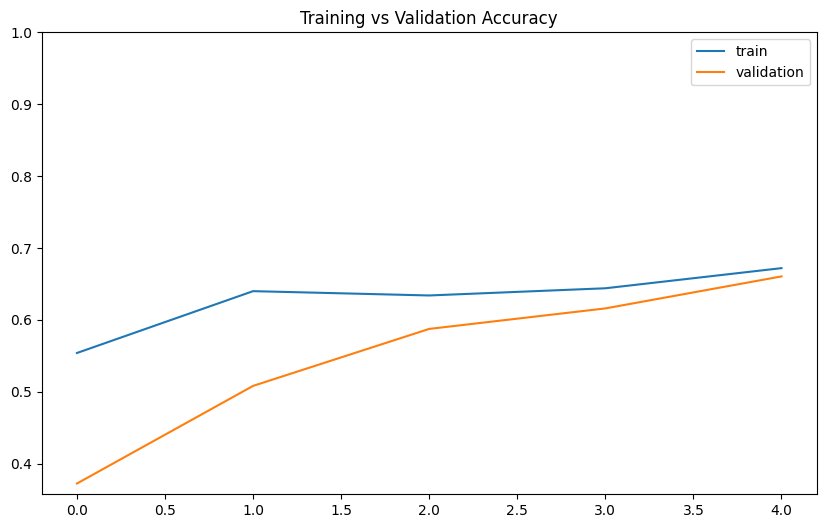

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Training vs Validation Accuracy")
plt.plot(baseline_train_accuracy, label='train')
plt.plot(baseline_val_accuracy, label='validation')
plt.ylim(top=1)
plt.legend()
plt.show()

# Part 4: Run Hyperparameter Experiments

# Initial thoughts
After examining the test results, it is clear that the model is underperforming. Due to the nature of the data, and the test data that I obtained (which I will explore later), I think it's important to augment the data to create a more robust model that isn't thrown off my additional markings you would see around notes on traditional sheet music.

Data augmentation will require a new set of transformations applied *only* to the training data. If I augment all data (train, test and validation) then I run the risk of overfitting again.

## Augmentation Experimentation

In [ ]:
from torch.utils.data import Subset
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder

# Defining a Transform for training data with augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1), # Guaranteeing only one color channel for efficiency
    transforms.Resize((64,64)), # Resizing image

    # Data augmentation to simulate real-world scans/handwritten music notes
    transforms.RandomRotation(degrees=(-10, 10)), # Rotates data 10 degrees either way
    transforms.RandomAffine(degrees=(0.1, 0.1)), # May translate/rotate image off center or out of crop
    transforms.GaussianBlur(kernel_size=3), # Blurs images

    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5)), # Normalizing pixel values to range from (0,1) and (-1,1) for stability
    transforms.RandomErasing(scale=(0.1, 0.25)), # Erases random splotches ranging in size from 1/10 to 1/4 of the image
])

# Necessary custom class to apply different transformations on the train/tes/val subsets
class TransformedSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

# Untransformed data
full_data = ImageFolder(root=path)

# Splitting data up
total_size = len(full_data)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = int(0.1 * total_size)

# Getting indeces of splits
indices = torch.randperm(len(full_data))
train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[train_size+val_size:]

# Grabbing subsets of the SAME ImageFolder instance to prevent data leaking
train_subset = Subset(full_data, train_idx)
val_subset   = Subset(full_data, val_idx)
test_subset  = Subset(full_data, test_idx)

train_data = TransformedSubset(train_subset, transform_train)
val_data   = TransformedSubset(val_subset, transform)
test_data  = TransformedSubset(test_subset, transform)

aug_train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
norm_val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
norm_test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
# TEMPORARY CELL FOR TESTING

aug_model = MusicCNN().to(device)

print(full_data.classes)

['Eight', 'Half', 'Quarter', 'Sixteenth', 'Whole']


In [ ]:
# Defining Parameters to be used on augmented data
params = {
    'lr': 0.001,
    'dropout_rate': 0.5,
    'fc_size': 256
}

# Training and evaluating model on augmented data
train_accuracy, val_accuracy = train_and_evaluate(params, aug_train_loader, norm_val_loader)
print(f"Validation Accuracy: {val_accuracy[-1]:.4f}")

Epoch 1/10, Loss: 0.8193
Epoch 2/10, Loss: 0.3371
Epoch 3/10, Loss: 0.2292
Epoch 4/10, Loss: 0.1643
Epoch 5/10, Loss: 0.1244
Validation Accuracy: 0.9780


# Hyperparameter Grid Search

In [ ]:
# Hyperparameter Grid Search

# Defining values to test over
learning_rates = [0.01, 0.001, 0.0001]
dropout_rates = [0.1, 0.3, 0.5]

best_params = {}
best_acc = 0
validations = []

# Searching through all iterations of hyperparameters
for lr in learning_rates:
  for dropout in dropout_rates:

    print(f"Testing: LR={lr}, Dropout={dropout}...")

    # Defining the parameters to build the model
    current_params = {
        'lr': lr,
        'dropout_rate': dropout,
        'fc_size': 256
    }

    train_hist, val_hist = train_and_evaluate(current_params,
                           aug_train_loader, # Using Augmented Data for best results
                           norm_val_loader)

    final_val_accuracy = val_hist[-1] # Ending validation accuracy

    if final_val_accuracy > best_acc:
      best_acc = final_val_accuracy
      best_params = current_params
      print(f"Found new best parameters: \n {best_params} \n with accuracy: {best_acc}")

Testing: LR=0.01, Dropout=0.1...
Epoch 1/5, Loss: 13.8198
Epoch 2/5, Loss: 1.2185
Epoch 3/5, Loss: 0.9309
Epoch 4/5, Loss: 0.7204
Epoch 5/5, Loss: 0.6490
Found new best parameters: 
 {'lr': 0.01, 'dropout_rate': 0.1, 'fc_size': 256} 
 with accuracy: 0.804
Testing: LR=0.01, Dropout=0.3...
Epoch 1/5, Loss: 6.0178
Epoch 2/5, Loss: 0.7871
Epoch 3/5, Loss: 0.5468
Epoch 4/5, Loss: 0.4039
Epoch 5/5, Loss: 0.2943
Found new best parameters: 
 {'lr': 0.01, 'dropout_rate': 0.3, 'fc_size': 256} 
 with accuracy: 0.922
Testing: LR=0.01, Dropout=0.5...
Epoch 1/5, Loss: 2.2342
Epoch 2/5, Loss: 0.9011
Epoch 3/5, Loss: 0.6959
Epoch 4/5, Loss: 0.5631
Epoch 5/5, Loss: 0.4954
Testing: LR=0.001, Dropout=0.1...
Epoch 1/5, Loss: 0.9446
Epoch 2/5, Loss: 0.4947
Epoch 3/5, Loss: 0.3485
Epoch 4/5, Loss: 0.2669
Epoch 5/5, Loss: 0.1935
Testing: LR=0.001, Dropout=0.3...
Epoch 1/5, Loss: 1.2511
Epoch 2/5, Loss: 0.7118
Epoch 3/5, Loss: 0.5218
Epoch 4/5, Loss: 0.4033
Epoch 5/5, Loss: 0.3045
Found new best parameters: 


In [ ]:
plt.figure(figsize=(10,6))
plt.title("Training vs Validation Accuracy of Grid Search")
plt.plot(baseline_val_accuracy, label='Original validation accuracy')
plt.plot(best_acc, label='validation')
plt.ylim(top=1)
plt.legend()
plt.show()

In [ ]:
# TODO - perform other experiments and plot accuracies

# Final Test Accuracy
Using the **best** parameters discovered above, it's time to evaluate the model on the completely unseen test data.

## Self-Collected Data Tests

The final tests I will conduct are on a dataset which I collected the data for.

In [22]:
# Mounting google drive to get uploaded dataset
# I realize this is from my personal Google Drive. I have included the data I collected in my submission under Notes.zip
from google.colab import drive
drive.mount('/content/drive')


! unzip /content/drive/MyDrive/Notes.zip -d /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Notes.zip
   creating: /content/Notes/
   creating: /content/Notes/Eight/
   creating: /content/Notes/Sixteenth/
  inflating: /content/Notes/.DS_Store  
replace /content/__MACOSX/Notes/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/__MACOSX/Notes/._.DS_Store  
   creating: /content/Notes/Half/
   creating: /content/Notes/Whole/
   creating: /content/Notes/Quarter/
  inflating: /content/Notes/Eight/eighth_7.jpeg  
  inflating: /content/__MACOSX/Notes/Eight/._eighth_7.jpeg  
  inflating: /content/Notes/Eight/eighth_6.jpeg  
  inflating: /content/__MACOSX/Notes/Eight/._eighth_6.jpeg  
  inflating: /content/Notes/Eight/eighth_1.jpeg  
replace /content/__MACOSX/Notes/Eight/._eighth_1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/__MACOSX/Notes/Eight/._eighth_1.jpeg  
  inflating: /c

### Data Analysis
Before evaluating the model's performance on my collected data, it's important to emphasize how different it is from my training data.

31


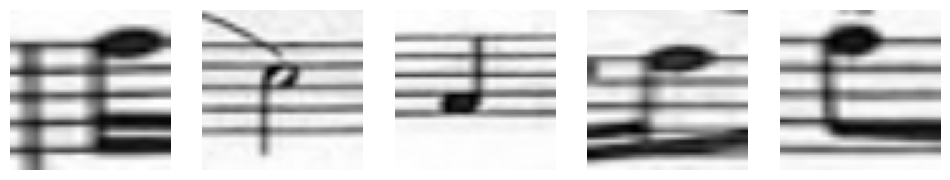

In [28]:
dir = '/content/Notes'
minuet_notes = ImageFolder(root=dir, transform=transform)
minuet_loader = DataLoader(minuet_notes, batch_size=BATCH_SIZE, shuffle=True)

temp_minuet_iter = iter(minuet_loader)
images, labels = next(temp_minuet_iter)
fig, axes = plt.subplots(1, 5, figsize=(12,3))

for i in range(5):
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap="gray")
  axes[i].axis("off")

plt.show()


In [30]:

# Running training evaluation on model performance against self-collected data using the best hyperparameters obtained through grid search

train_acc, test_acc = train_and_evaluate(best_params, aug_train_loader, minuet_loader)
print(f"Test Accuracy: {test_acc[-1]:.4f}")


Epoch 1/5, Loss: 0.9992
Epoch 2/5, Loss: 0.5326
Epoch 3/5, Loss: 0.3896
Epoch 4/5, Loss: 0.3005
Epoch 5/5, Loss: 0.2526
Test Accuracy: 0.4516


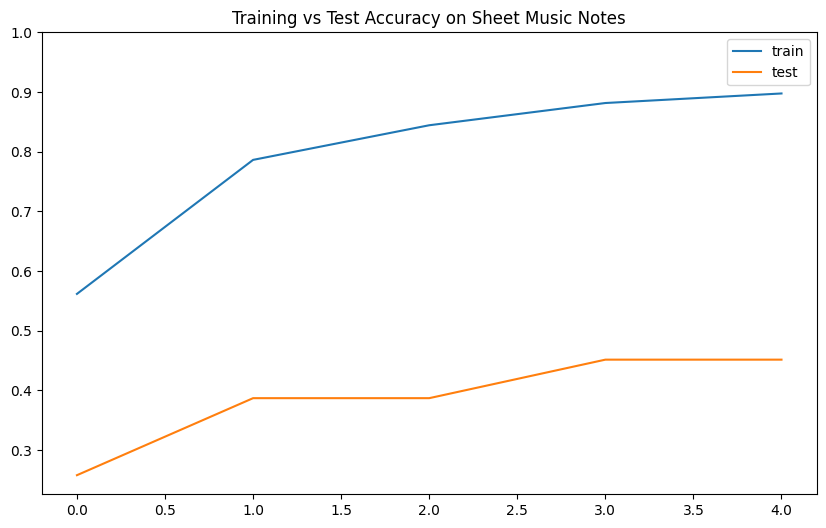

In [32]:
plt.figure(figsize=(10,6))
plt.title("Training vs Test Accuracy on Sheet Music Notes")
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.ylim(top=1)
plt.legend()
plt.show()

# Results
The above accuracies for the test data from the original dataset and the test data from my collected data set match what we would expect for a well CNN model.

### Test Results
The 10% test data, evaluated against a model trained on augmented data using the best-known hyperparameters, yields an accuracy of **%**

In [ ]:
# TODO - calculate the final test accuracy

In [31]:

print(test_acc)

[0.25806451612903225, 0.3870967741935484, 0.3870967741935484, 0.45161290322580644, 0.45161290322580644]


TODO - Explain your experiments above. See assignment doc for more details.